In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.0 Data Preprocessing

In [3]:
# I did this on IBM cloud where file size limit was 256 MB. Hence I removed duplicates.
# Also, the score has been turned into binary class- Positive and Negative

con = sqlite3.connect(r"final.sqlite")
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)
filtered_data.shape

(364171, 11)

In [4]:
# Taking first 100,000 points for analysis

filtered_data = filtered_data.sort_values(by=['Time'])
final = filtered_data[:100000]
final.Score.value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [5]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        #print(i)
        #print(sent)
        break;
    i += 1;    

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

stop = set(stopwords.words('english')) #set of stopwords
sno = SnowballStemmer('english') #initialising the snowball stemmer

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kushalkul01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [7]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [8]:
final = final.sort_values(by=['Time']) #Just to be double sure that dataframe is sorted according to time

# Taking labels to make y-dimension
labels=final['Score'].values

# Checking the shape of labels
print("Shape of y-vector is",labels.shape)

Shape of y-vector is (100000,)


# 2.0 Bag of Words Model

In [10]:
# Making the bag of words model

from sklearn.feature_extraction.text import CountVectorizer
bow=CountVectorizer()
final_counts=bow.fit_transform(final['CleanedText'])

In [11]:
# Taking first 70% as Training-data and remaining 30% as Test-data. As data is already sorted
# according to timestamp, merely index-based splitting will give us Time Based Splitting

l = 0.7 * final_counts.shape[0]
X_train_bow = final_counts[0:int(l)]
y_train_bow = labels[0:int(l)]
X_test_bow = final_counts[int(l):]
y_test_bow = labels[int(l):]

### 2.1 Bernoulli Naive Bayes

In [13]:
# Applying Bernoulli Naive-Bayes 

alpha=np.linspace(10**-4,10**1, 50) # taking 50 values between 10^-4 to 10 to do CV 
cv_scores = []
for i in alpha:
    nb_bow=BernoulliNB(alpha=i)
    scores = cross_val_score(nb_bow, X_train_bow, y_train_bow, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

In [14]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
bern_bow_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal alhpa value for Bernoulli Naive-Bayes on Bag-of-Words (BoW) model is %f.' % bern_bow_alpha)
print("Maximum score the model is {:.2f} %.".format(max(cv_scores) * 100))


The optimal alhpa value for Bernoulli Naive-Bayes on Bag-of-Words (BoW) model is 0.000100.
Maximum score the model is 90.14 %.


In [15]:
# Fitting Bernoulli Naive-Bayes with optimal alpha

bn_bow = BernoulliNB(alpha=bern_bow_alpha)
bn_bow.fit(X_train_bow , y_train_bow)

BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)

In [16]:
# predicting the values and calculating accuracy score

y_pred_bow = bn_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_pred_bow,y_test_bow)
print("Accuracy score for the model on test data is {:.2f} %.".format(accuracy_bow * 100))

Accuracy score for the model on test data is 89.24 %.


Confusion Matrix:


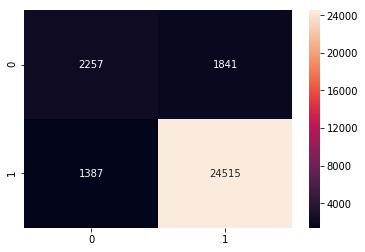

TPR for the model on test data is 94.65
FPR for the model on test data is 44.92
TNR for the model on test data is 55.08
FNR for the model on test data is 5.35



In [17]:
# Printing the confusion matrix

cm_bern_bow = confusion_matrix(y_test_bow , y_pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bern_bow, annot =True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_bern_bow.ravel()

tnr_bow = tn/(tn+fp)
fpr_bow = fp/(tn+fp)
fnr_bow = fn/(fn+tp)
tpr_bow = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_bow*100))
print("FPR for the model on test data is {:.2f}".format(fpr_bow*100))
print("TNR for the model on test data is {:.2f}".format(tnr_bow*100))
print("FNR for the model on test data is {:.2f}\n".format(fnr_bow*100))

In [18]:
# calculating precision, recall and confusion-matrix 
# as precision_score expect matrix in [0,1] form instead of [Positive, Negative]
# Same goes with recall_score and f1_score

yTestBow = y_test_bow=='Positive'
yPredBow = y_pred_bow=='Positive'
precision_bow = precision_score(yTestBow , yPredBow)
recall_bow = recall_score(yTestBow , yPredBow)
f1_bow = f1_score(yTestBow , yPredBow)

print("Precision score for the model on test data is {:.2f}".format(precision_bow))
print("Recall score for the model on test data is {:.2f}".format(recall_bow))
print("F1 score for the model on test data is {:.2f}\n".format(f1_bow))

Precision score for the model on test data is 0.93
Recall score for the model on test data is 0.95
F1 score for the model on test data is 0.94



In [19]:
# Taking values for probabilities for BoW

neg_bow = bn_bow.feature_log_prob_[0, :].argsort()
pos_bow = bn_bow.feature_log_prob_[1, :].argsort()

# Taking words with Maximum Probabilities
neg_words = np.take(bow.get_feature_names(), neg_bow[-10:])
pos_words = np.take(bow.get_feature_names(), pos_bow[-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['get' 'buy' 'flavor' 'good' 'tri' 'would' 'one' 'product' 'like' 'tast']

Positive Words are:
 ['tri' 'product' 'use' 'one' 'flavor' 'love' 'good' 'great' 'like' 'tast']


### 2.2 Multinomial Naive Bayes

In [20]:
# Applying Multinomial Naive-Bayes 

alpha=np.linspace(10**-4,10**1, 50) # taking 50 values between 10^-4 to 10 to do CV 
cv_scores = []
for i in alpha:
    mb_bow=MultinomialNB(alpha=i)
    scores = cross_val_score(mb_bow, X_train_bow, y_train_bow, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

In [21]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
mult_bow_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal alhpa value for the model is %f.' % mult_bow_alpha)
print("Maximum score for BoW model is {:.2f} %.".format(max(cv_scores) * 100))


The optimal alhpa value for the model is 1.428657.
Maximum score for BoW model is 91.09 %.


In [22]:
# Fitting Multinomial Naive-Bayes with optimal alpha

mb_bow = MultinomialNB(alpha=mult_bow_alpha)
mb_bow.fit(X_train_bow , y_train_bow)

MultinomialNB(alpha=1.4286571428571428, class_prior=None, fit_prior=True)

In [23]:
# predicting the values and calculating accuracy score

y_pred_bow = mb_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_pred_bow,y_test_bow)
print("Accuracy score for the model on test data is {:.2f} %.".format(accuracy_bow * 100))

Accuracy score for the model on test data is 90.24 %.


Confusion Matrix:


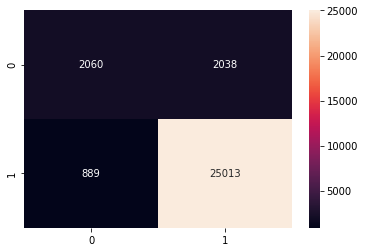

TPR for BoW model on test data is 96.57
FPR for BoW model on test data is 49.73
TNR for BoW model on test data is 50.27
FNR for BoW model on test data is 3.43



In [24]:
# Printing the confusion matrix

cm_mult_bow = confusion_matrix(y_test_bow , y_pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_mult_bow, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_mult_bow.ravel()

tnr_bow = tn/(tn+fp)
fpr_bow = fp/(tn+fp)
fnr_bow = fn/(fn+tp)
tpr_bow = tp/(fn+tp)

print("TPR for BoW model on test data is {:.2f}".format(tpr_bow*100))
print("FPR for BoW model on test data is {:.2f}".format(fpr_bow*100))
print("TNR for BoW model on test data is {:.2f}".format(tnr_bow*100))
print("FNR for BoW model on test data is {:.2f}\n".format(fnr_bow*100))

In [25]:
# calculating precision and recall
# as precision_score expect matrix in [0,1] form instead of [Positive, Negative]
# Same goes with recall_score and f1_score

yTestBow = y_test_bow=='Positive'
yPredBow = y_pred_bow=='Positive'
precision_bow = precision_score(yTestBow , yPredBow)
recall_bow = recall_score(yTestBow , yPredBow)
f1_bow = f1_score(yTestBow , yPredBow)


print("Precision score for BoW model on test data is {:.2f}".format(precision_bow))
print("Recall score for BoW model on test data is {:.2f}".format(recall_bow))
print("F1 score for BoW model on test data is {:.2f}\n".format(f1_bow))

Precision score for BoW model on test data is 0.92
Recall score for BoW model on test data is 0.97
F1 score for BoW model on test data is 0.94



In [26]:
# Taking values for probabilities for BoW

neg_bow = mb_bow.feature_log_prob_[0, :].argsort()
pos_bow = mb_bow.feature_log_prob_[1, :].argsort()

# Taking words with Maximum Probabilities
neg_words = np.take(bow.get_feature_names(), neg_bow[-10:])
pos_words = np.take(bow.get_feature_names(), pos_bow[-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['tea' 'use' 'good' 'would' 'tri' 'flavor' 'one' 'product' 'like' 'tast']

Positive Words are:
 ['product' 'one' 'use' 'love' 'great' 'flavor' 'good' 'tea' 'tast' 'like']


# 3.0 TF-IDF

In [27]:
# importing the right libraries

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# making tf-idf vector

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)


# checking the properties of tf-idf vector

print("The type of count vectorizer ",type(final_tf_idf))
print("The shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("The number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (100000, 1190020)
The number of unique words including both unigrams and bigrams  1190020


In [28]:
# Taking first 70% as Training-data and remaining 30% as Test-data

l = 0.7 * final_tf_idf.shape[0]
X_train_tf = final_tf_idf[0:int(l)]
y_train_tf = labels[0:int(l)]
X_test_tf = final_tf_idf[int(l):]
y_test_tf = labels[int(l):]

### Bernoulli Naive-Bayes

In [29]:
# Applying Cross-Validation to find optimal alpha 

alpha=np.linspace(10**-5,10, 50) # taking 100 values between 10^-4 to 10 to do CV 
cv_scores = []
for i in alpha:
    nb_tf=BernoulliNB(alpha=i)
    scores = cross_val_score(nb_tf, X_train_tf, y_train_tf, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

In [30]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
bern_tf_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal alhpa value for the model is %f.' % bern_tf_alpha)
print("Maximum score for the model is {:.2f} %.".format(max(cv_scores) * 100))


The optimal alhpa value for the model is 0.000010.
Maximum score for the model is 90.03 %.


In [31]:
# Fitting Bernoulli Naive-Bayes with optimal alpha

bn_tf=BernoulliNB(alpha=bern_tf_alpha)
bn_tf.fit(X_train_tf , y_train_tf)

BernoulliNB(alpha=1e-05, binarize=0.0, class_prior=None, fit_prior=True)

In [32]:
# predicting the values and calculating accuracy score

y_pred_tf = bn_tf.predict(X_test_tf)
accuracy_tf = accuracy_score(y_test_tf , y_pred_tf)
print("Accuracy score for TF-IDF model on test data is {:.2f} %.".format(accuracy_tf * 100))

Accuracy score for TF-IDF model on test data is 88.56 %.


Confusion Matrix:



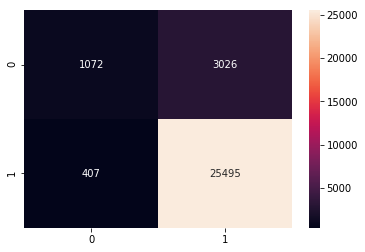

TPR for TF-IDF model on test data is 98.43
FPR for TF-IDF model on test data is 73.84
TNR for TF-IDF model on test data is 26.16
FNR for TF-IDF model on test data is 1.57


In [33]:
# Printing the confusion matrix

cm_bern_tf = confusion_matrix(y_test_tf , y_pred_tf)
print("Confusion Matrix:\n")
sns.heatmap(cm_bern_tf, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_bern_tf.ravel()

tnr_tf = tn/(tn+fp)
fpr_tf = fp/(tn+fp)
fnr_tf = fn/(fn+tp)
tpr_tf = tp/(fn+tp)

print("TPR for TF-IDF model on test data is {:.2f}".format(tpr_tf*100))
print("FPR for TF-IDF model on test data is {:.2f}".format(fpr_tf*100))
print("TNR for TF-IDF model on test data is {:.2f}".format(tnr_tf*100))
print("FNR for TF-IDF model on test data is {:.2f}".format(fnr_tf*100))

In [34]:
# as precision_score expect matrix in [0,1] form instead of [Positive, Negative]
# Same goes with recall_score and f1_score

yTestTF = y_test_tf=='Positive'
yPredTF = y_pred_tf=='Positive'

# calculating precision, recall and confusion-matrix

precision_tf = precision_score(yTestTF , yPredTF)
recall_tf = recall_score(yTestTF , yPredTF)
f1_tf = f1_score(yTestTF , yPredTF)


print("Precision score for the model on test data is {:.2f}".format(precision_tf))
print("Recall score for the model on test data is {:.2f}".format(recall_tf))
print("F1 score for the model on test data is {:.2f}".format(f1_tf))

Precision score for the model on test data is 0.89
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.94


In [35]:
# Taking values for probabilities for BoW

neg_tf = bn_tf.feature_log_prob_[0, :].argsort()
pos_tf = bn_tf.feature_log_prob_[1, :].argsort()

# Taking words with Maximum Probabilities for negative and positive labels
neg_words = np.take(tf_idf_vect.get_feature_names(), neg_tf[-10:])
pos_words = np.take(tf_idf_vect.get_feature_names(), pos_tf[-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['get' 'buy' 'flavor' 'good' 'tri' 'would' 'one' 'product' 'like' 'tast']

Positive Words are:
 ['tri' 'product' 'use' 'one' 'flavor' 'love' 'good' 'great' 'like' 'tast']


### Multinomial Naive-Bayes

In [37]:
# Applying Cross-Validation to find optimal alpha 

alpha=np.linspace(10**-5,10, 50) # taking 100 values between 10^-5 to 10 to do CV 
cv_scores = []
for i in alpha:
    nm_tf= MultinomialNB(alpha=i)
    scores = cross_val_score(nm_tf, X_train_tf, y_train_tf, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

In [38]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
mult_tf_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal alhpa value for MultinomialNB on TF-IDF model is %f.' % mult_tf_alpha)
print("Maximum score for the model is {:.2f} %.".format(max(cv_scores) * 100))


The optimal alhpa value for MultinomialNB on TF-IDF model is 0.000010.
Maximum score for the model is 89.84 %.


In [39]:
# Fitting Multinomial Naive-Bayes with optimal alpha

mn_tf=MultinomialNB(alpha=mult_tf_alpha)
mn_tf.fit(X_train_tf , y_train_tf)

MultinomialNB(alpha=1e-05, class_prior=None, fit_prior=True)

In [40]:
# predicting the values and calculating accuracy score

y_pred_tf = mn_tf.predict(X_test_tf)
accuracy_tf = accuracy_score(y_test_tf , y_pred_tf)
print("Accuracy score for the test data is {:.2f} %.".format(accuracy_tf * 100))

Accuracy score for the test data is 88.32 %.


Confusion Matrix:



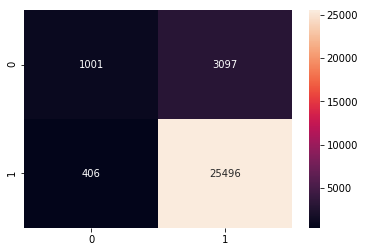

TPR for the model on test data is 98.43
FPR for the model on test data is 75.57
TNR for the model on test data is 24.43
FNR for the model on test data is 1.57


In [41]:
# Printing the confusion matrix

cm_mult_tf = confusion_matrix(y_test_tf , y_pred_tf)
print("Confusion Matrix:\n")
sns.heatmap(cm_mult_tf, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_mult_tf.ravel()

tnr_tf = tn/(tn+fp)
fpr_tf = fp/(tn+fp)
fnr_tf = fn/(fn+tp)
tpr_tf = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_tf*100))
print("FPR for the model on test data is {:.2f}".format(fpr_tf*100))
print("TNR for the model on test data is {:.2f}".format(tnr_tf*100))
print("FNR for the model on test data is {:.2f}".format(fnr_tf*100))

In [42]:
# as precision_score expect matrix in [0,1] form instead of [Positive, Negative]
# Same goes with recall_score and f1_score

yTestTF = y_test_tf=='Positive'
yPredTF = y_pred_tf=='Positive'

# calculating precision, recall and confusion-matrix

precision_tf = precision_score(yTestTF , yPredTF)
recall_tf = recall_score(yTestTF , yPredTF)
f1_tf = f1_score(yTestTF , yPredTF)


print("Precision score for the model on test data is {:.2f}".format(precision_tf))
print("Recall score for the model on test data is {:.2f}".format(recall_tf))
print("F1 score for the model on test data is {:.2f}".format(f1_tf))

Precision score for the model on test data is 0.89
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.94


In [43]:
# Taking values for probabilities for BoW

neg_tf = mn_tf.feature_log_prob_[0, :].argsort()
pos_tf = mn_tf.feature_log_prob_[1, :].argsort()

# Taking words with Maximum Probabilities for negative and positive labels
neg_words = np.take(tf_idf_vect.get_feature_names(), neg_tf[-10:])
pos_words = np.take(tf_idf_vect.get_feature_names(), pos_tf[-10:])

print("Negative Words are:\n" , neg_words, end='\n\n')
print("Positive Words are:\n" , pos_words)

Negative Words are:
 ['tea' 'buy' 'order' 'tri' 'flavor' 'one' 'would' 'product' 'like' 'tast']

Positive Words are:
 ['one' 'use' 'product' 'flavor' 'like' 'love' 'good' 'tast' 'great' 'tea']


# 4.0 Conclusion

Naive-Bayes algorithm was successfully applied on Amazon Food Reviews dataset to check for the polarity of the review.

In order to accomplish this task, 2 types of Text processing techniques, namely Bag of Words and TF-IDF were applied. First the optimal value of alpha was estimated using cross validation and then the model was fit using the value of optimal alpha.

Post successful fitting of the model, the polarity (labels) on the test dataset was estimated using the model and was checked against the true polarity. Based on this, Accuracy, Precision-Score, Recall Score and F1-Score were calculated. 

The values of all the parameters are tabulated in the following table-


<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Model</th>
    <th>Algorithm</th>
    <th>Best Alpha</th>
    <th>Cross Validation Accuracy</th>
    <th>Test Accuracy</th>
    <th>Precision Score</th>
    <th>Recall Score</th>
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Bag-of-Words</td>
    <td>BernoulliNB</td>
    <td> 0.0001</td>
    <td>90.14 %</td>
    <td>89.24 %</td>
    <td>0.93</td>
    <td>0.95</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>Bag-of-Words</td>
    <td>MultinomialNB</td>
    <td>1.42</td>
    <td>91.09 %</td>
    <td>90.24 %</td>
    <td>0.92</td>
    <td>0.97</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>BernoulliNB</td>
    <td>0.00001</td>
    <td>90.03 %</td>
    <td>88.56 %</td>
    <td>0.89</td>
    <td>0.98</td>
    <td>0.94</td>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>MultinomialNB</td>
    <td>0.00001</td>
    <td>89.84 %</td>
    <td>88.32 %</td>
    <td>0.89</td>
    <td>0.98</td>
    <td>0.94</td>
  </tr>
 
</table>



</body>
</html>

### Observations

1. In terms of F1-Score, all techniques perform almost similar.
2. The distinct words for both positive and negative reviews are quite similar.